## Imports

In [ ]:
#!dcm2niix -h
#!dcm2niix Brain_T1_scan_Patient1

In [37]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import norm as normal
from skimage.io import imread
from skimage.color import rgb2grey
from IPython import display
import math as m
import random
import matplotlib.patches as mpatches
from scipy.ndimage import morphology
import copy


## Histogram equalization

In [1]:


file_path = "Nifti_Brain/Brain_T1_scan_Patient1_Sag_T1_MPRAGE_1x1x1_20210108134957_2.nii"
img=nib.load(file_path)
data=img.get_fdata()

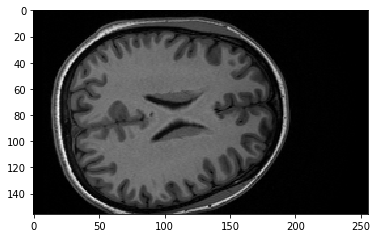

In [2]:

plt.imshow(data[:,:,190], cmap='gray')
plt.show()


In [3]:
grey_im = (data*(255/data.max())).astype(np.uint8)

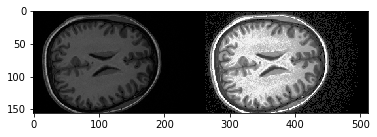

0


In [5]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html



img = grey_im[:,:,190]
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side

plt.imshow(res, cmap='gray')
plt.show()
print(img[20][200])

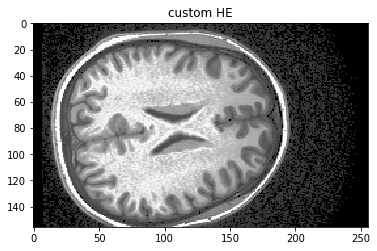

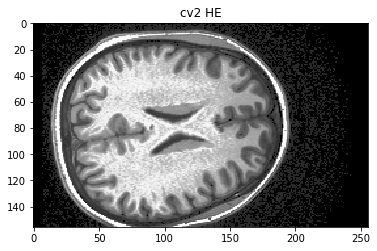

In [8]:
#Own implementation of the histogram equalization

#The goal of the H.E is to have a linear cumulative distribution function (cdf)
#a cross the range of intensity to have a better use of all possible intensities.
#



def hist_equalizer(img):
    
    result = np.zeros(img.shape).astype(np.uint8)
    
    #Set the range of intensity of the image between 0 and 255 and as unsigned integers
    grey_im = (img*(255/img.max())).astype(np.uint8)
    
    #Create the histogram
    #We got up to 256 because the last bin is [255,256] while all the others are [n-1,n[
    #meaning that the last bin would have sum the pixels with value 254 and 255 if we had stop at 255
    counts, bins = np.histogram(grey_im.flatten(),256, [0,256])
    
    #Create the cdf
    cdf = counts.cumsum()
    cdf_min = cdf[np.nonzero(cdf)[0][0]] #first element that is not zero
    
    i_max, j_max = img.shape
    
    for i in range(i_max):
        for j in range(j_max):
            #value in the original image to be transformed
            val = grey_im[i][j]

            #we just take the normalized cdf of the value by the inverse distribution 
            #function (quantile function) multiply it by 255 (the max range) and round the result
            result[i][j] = m.floor((cdf[val] - cdf_min)/(i_max*j_max - cdf_min)*(256-1))

    return result

custom_res = hist_equalizer(data[:,:,190])

plt.imshow(custom_res,cmap='gray')
plt.title("custom HE")
plt.show()

plt.imshow(equ,cmap='gray')
plt.title("cv2 HE")
plt.show()

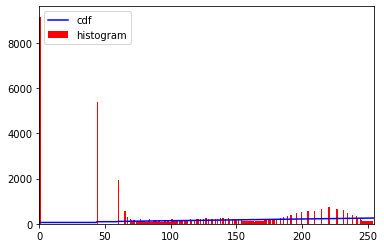

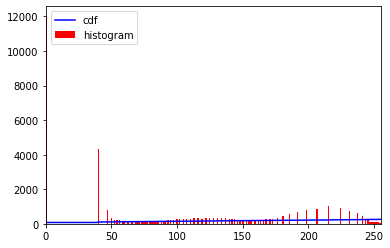

In [9]:
#Comparing histogram of custom and cv2 histogram equalizer

hists, bins = np.histogram(custom_res, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(custom_res.flatten(), 256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

hists, bins = np.histogram(equ, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

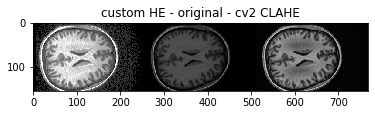

In [10]:
#Contrast-limited adaptive histogram equalization (CLAHE) consist of dividing the image into tiles
#and apply the equalization localy. There is also a threshold to limit the contrast
#TODO better explanation

img = grey_im[:,:,190]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #grid of 8 by 8
cl1 = clahe.apply(img)
res = np.hstack((custom_res,img,cl1))
plt.imshow(res, cmap='gray')
plt.title('custom HE - original - cv2 CLAHE')
plt.show()

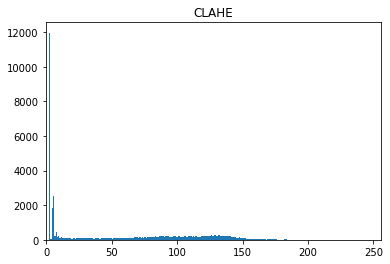

In [11]:
counts, bins = np.histogram(cl1, range(257))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.title("CLAHE")
plt.show()

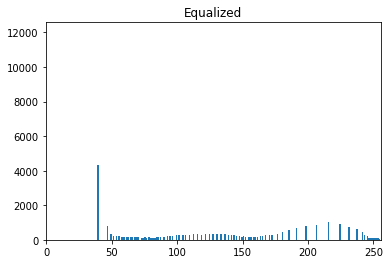

In [12]:
counts, bins = np.histogram(equ, range(257))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.title("Equalized")
plt.show()

## Segmentation GM/WM

In [14]:
## Usefull functions cell 
  
def getForegroundMask(originalBrainImg, backGroundValue=0):
    # Get a binary mask from an array, where the pixels > 0 are set to 1
    foregroundMask = originalBrainImg > backGroundValue
    return binary_fill_holes(foregroundMask)

def getForegroundArray(originalBrainImg, foregroundMask):
    # Return a 1D array with the pixels from originalBrainImg which are under the foregroundmask
    return originalBrainImg[foregroundMask==1]
 
def plotHistogramWithDistribs(array, meansArray, stdsArray):
    # Plot the histogram of an array and gaussian distributions corresponding to meansArray / stdsArray
    plt.figure(figsize=(10, 10))
    hist, bin_edges = np.histogram(array, bins=255, normed=True)
    plt.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Intensity')
    x = np.linspace(0, 1, 255)
    for (mean, std) in zip(meansArray, stdsArray):
        plt.plot(x, normal.pdf(x, mean, std), linewidth=1)
        
def plotHistogramWithTresholds(array, tresh):
    # Plot the histogram of an array and gaussian distributions corresponding to meansArray / stdsArray
    plt.figure(figsize=(10, 10))
    hist, bin_edges = np.histogram(array, bins=255, normed=True)
    plt.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Intensity')
    x = np.linspace(0, 1, 255)
    for i in tresh:
        plt.axvline(x = i,color = 'red')

In [29]:

## Read and rescale image between 0 and 1 
originalBrainImg = data[:,:,188:192]

originalBrainImg = originalBrainImg / np.max(originalBrainImg)
for i in range(originalBrainImg.shape[0]):
    for j in range(originalBrainImg.shape[1]):
        for z in range(originalBrainImg.shape[2]):
            if originalBrainImg[i,j,z]<0.05:
                 originalBrainImg[i,j,z]=0.0


## Get only non zeros pixels from the image (Use functions from previous cell)
ZeroBrainImg = getForegroundArray(originalBrainImg,getForegroundMask(originalBrainImg,0.05))

 Otsu method

In [32]:
def OtsuSeg(BrainImg, tresh):
    SegmentedBrain = np.zeros(BrainImg.shape)
    for i in range(BrainImg.shape[0]):
        for j in range(BrainImg.shape[1]):
            for z in range(BrainImg.shape[2]):
                if BrainImg[i,j,z] > 0 and BrainImg[i,j,z] <= tresh[0] :
                    SegmentedBrain[i,j,z] = 1/3
                elif BrainImg[i,j,z] > tresh[0] and BrainImg[i,j,z] <= tresh[1] :
                    SegmentedBrain[i,j,z] = 2/3
                elif BrainImg[i,j,z] > tresh[1]:
                    SegmentedBrain[i,j,z] = 1
    return SegmentedBrain
tresh = [0.15,0.35]
            

C:\Users\MediMonster\anaconda3\lib\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


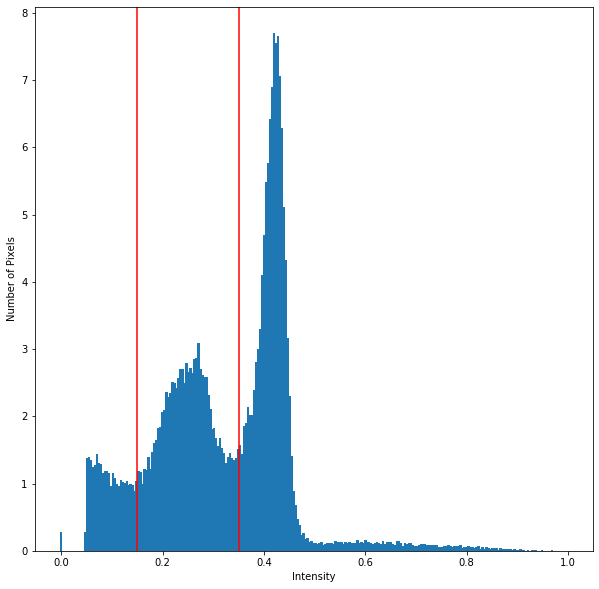

In [34]:
plotHistogramWithTresholds(ZeroBrainImg, tresh)
OtsuBrain = OtsuSeg(originalBrainImg,tresh)

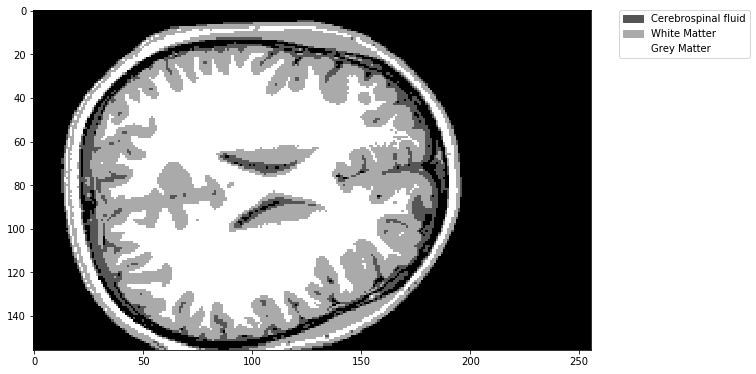

In [35]:
## Show EM segmentation results



values = np.unique(OtsuBrain.ravel())
values = values[1:]

plt.figure(figsize=(10,10))
im = plt.imshow(OtsuBrain[:,:,2],cmap=plt.cm.gray)

# get the colors of the values, according to the 
# colormap used by imshow

colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
labels = {0: 'Cerebrospinal fluid',1:'White Matter',2:'Grey Matter'}

patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

E-M Method

initialMeansArray [0.25 0.45]
initialStdsArray [0.1  0.05]


C:\Users\MediMonster\anaconda3\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


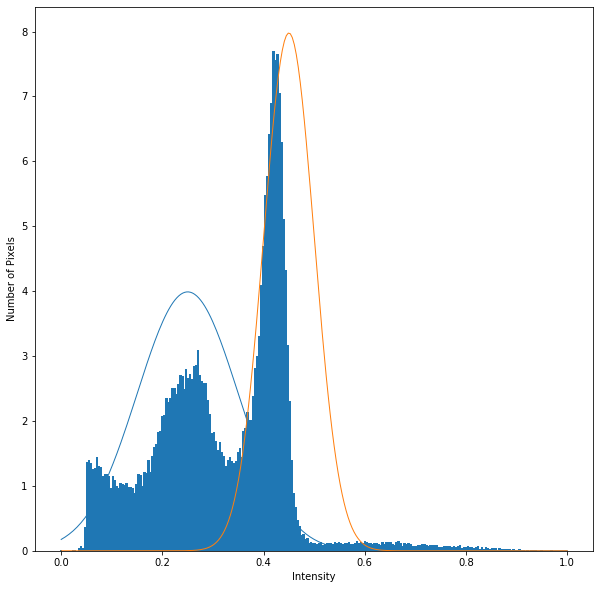

In [22]:
%matplotlib inline




## Define classes for the classification
classList = ['GreyMatter', 'WhiteMatter']
numberOfClasses = len(classList)

## Initial conditions (You can change them)
initialMeansArray = np.array([0.25,0.45])
initialStdsArray = np.array([0.1,0.05])
priorProbabilities = [0.5,0.5]

print('initialMeansArray', initialMeansArray)
print('initialStdsArray', initialStdsArray)
plotHistogramWithDistribs(ZeroBrainImg, initialMeansArray, initialStdsArray)

In [17]:



def em(brainArray,pixelArray, meanArray, stdArray, priorProbs, tol=1e-4, max_iter=1000):
    
    ## TO COMPLETE
    
    ## ---------------------if you want to see the optimisation steps---------------------
    colorList = ['r', 'g', 'b']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    hist, bin_edges = np.histogram(pixelArray, bins=255, normed=True)
    ax.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Grey Levels')
    x = np.linspace(0, 1, 255)
    ## -----------------------------------------------------------------------------------
    
    meansArray = meanArray.copy()
    stdsArray = stdArray.copy()
    mean_diff = 1
    std_diff = 1
    pixel_x = brainArray.shape[0]
    pixel_y = brainArray.shape[1]
    pixel_z = brainArray.shape[2]

    nb_set = meansArray.shape[0]
    
    uniquePixelValues,count = np.unique(pixelArray,return_counts = True)
    #pour enlever 0
    uniquePixelValues = uniquePixelValues[1:]

    count = count[1:]
    print(count)
    
    pixel_diff = uniquePixelValues.shape[0]
    print(pixel_diff)
    
    # Create empty matrix of the shape you need
    pixels_class_probs = np.zeros((pixel_diff,nb_set))
    class_prob = np.zeros((pixel_diff,nb_set))
    for i in range(nb_set):
        pixels_class_probs[:,i] = (1.0/(m.sqrt(2*m.pi)*stdsArray[i]))*np.exp(-0.5*np.square((uniquePixelValues-meansArray[i])/stdsArray[i]))

    for iterNumber in range(max_iter):
        if (mean_diff < tol and std_diff < tol):
            break
        
        print('Iteration : ', iterNumber)
        
        # Step E(xpectaction)
        for i in range(nb_set):
            class_prob[:,i] = ((pixels_class_probs[:,i])*priorProbs[i])/np.sum(pixels_class_probs*priorProbs,axis=1)    
        
        

        # Step M(aximization)
        oldMean = meansArray.copy()
        oldStd = stdsArray.copy()
        for i in range(nb_set):
            meansArray[i] = np.sum(class_prob[:,i]*count*uniquePixelValues)/np.sum(count*class_prob[:,i])
            stdsArray[i] = m.sqrt(np.sum(count*class_prob[:,i]*(uniquePixelValues-meansArray[i])**2)/np.sum(count*class_prob[:,i]))

        
        
        
        # Update prior probabilities
        for i in range(nb_set):
            pixels_class_probs[:,i] = (1.0/(m.sqrt(2*m.pi)*stdsArray[i]))*np.exp(-0.5*np.square((uniquePixelValues-meansArray[i])/stdsArray[i]))
 
        
        # Compute convergence conditions to check in next iteration
        mean_diff = max(abs(meansArray-oldMean))
        std_diff = max(abs(stdsArray-oldStd))
        
        
        
         ## ---------------------if you want to see the optimisation steps---------------------
        for elem in ax.lines:
            elem.remove()
        for i in range(meansArray.shape[0]):
            ax.plot(x, normal.pdf(x, meansArray[i], stdsArray[i]), linewidth=1, color=colorList[i])
        display.clear_output(wait=True)
        display.display(plt.gcf())
        ##-----------------------------------------------------------------------------------
        

    
    SegmentedBrain = np.zeros((pixel_x,pixel_y,pixel_z))
    for i in range(pixel_diff):
        x,y,z = np.where(brainArray == uniquePixelValues[i])
        SegmentedBrain[x,y,z] = random.choices(range(1,nb_set+1),weights = class_prob[i,:],k=len(x))

        
    return class_prob, meansArray, stdsArray, SegmentedBrain

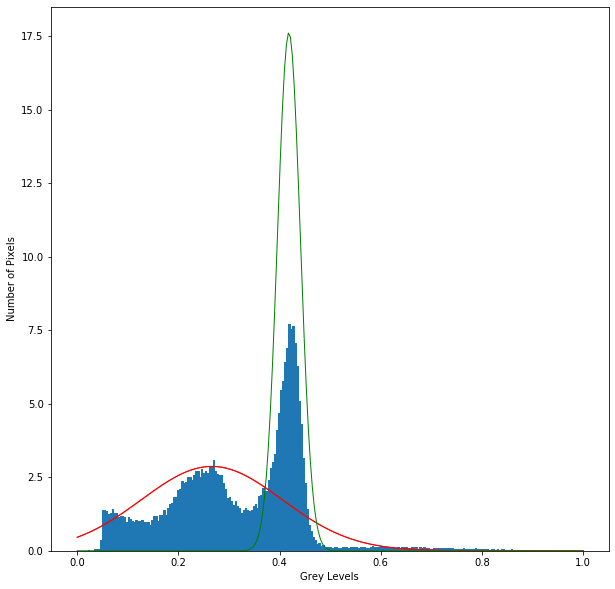

[0.00239107 0.00478215 0.02497343 ... 0.97077577 0.97582359 1.        ]
[1 1 2 ... 1 1 1]
[0.26635663 0.41833045]
[0.13889759 0.02263398]


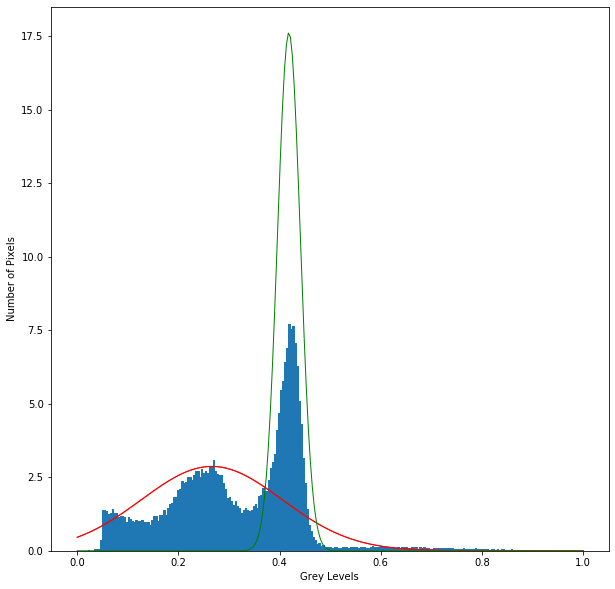

In [24]:
%matplotlib inline

class_prob, finalMeansArray, finalStdsArray,EMBrain = em(originalBrainImg,
                                                 ZeroBrainImg,
                                                initialMeansArray, 
                                                initialStdsArray, 
                                                priorProbabilities, 
                                                tol=1e-3, 
                                                max_iter=100)

print(finalMeansArray)
print(finalStdsArray)

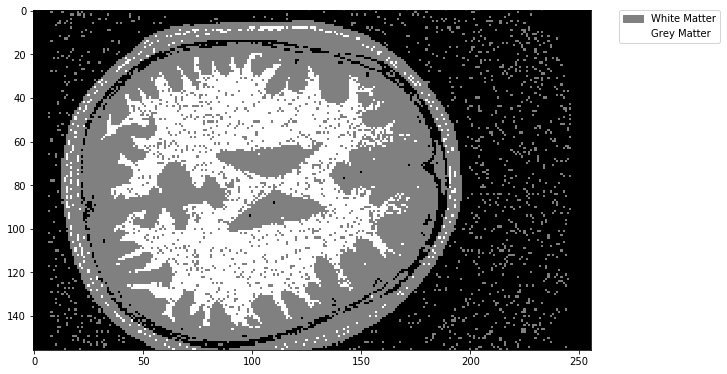

In [25]:
## Show EM segmentation results



values = np.unique(EMBrain.ravel())
values = values[1:]

plt.figure(figsize=(10,10))
im = plt.imshow(EMBrain[:,:,2],cmap=plt.cm.gray)

# get the colors of the values, according to the 
# colormap used by imshow

colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
labels = {0:'White Matter',1:'Grey Matter'}

patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()


In [38]:


whiteBrain = copy.deepcopy(EMBrain)

for i in range(EMBrain.shape[0]):
    for j in range(EMBrain.shape[1]):
        for z in range(EMBrain.shape[2]):
            if EMBrain[i,j,z] != 2:
                whiteBrain[i,j,z] = 0
            
#Lets refine the segmentation

new_morpho = morphology.binary_closing(whiteBrain)
new_morpho2 = morphology.binary_opening(new_morpho)

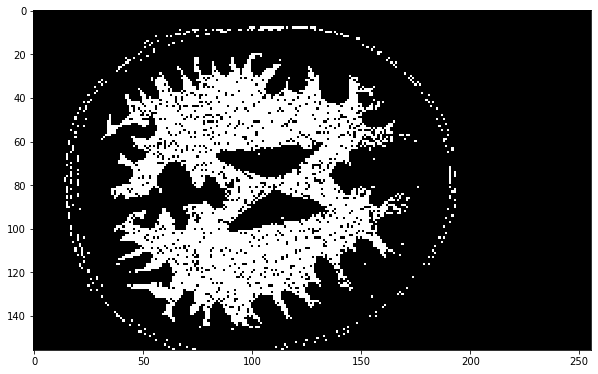

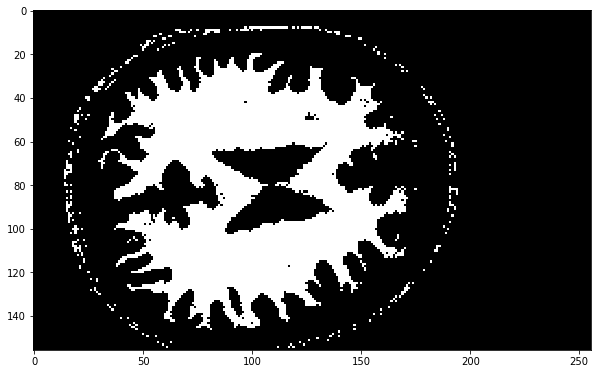

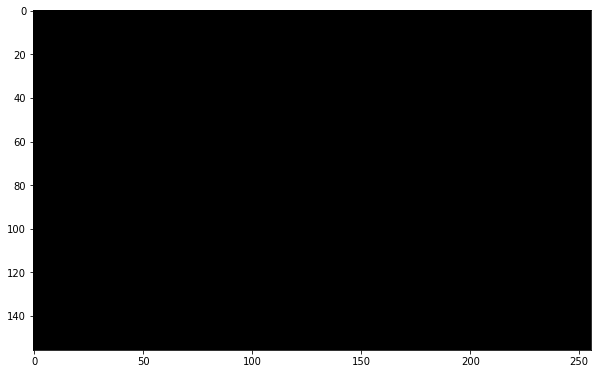

In [42]:
plt.figure(figsize=(10,10))
white = plt.imshow(whiteBrain[:,:,2],cmap=plt.cm.gray)

plt.show()


#The white matter in the brain with mathematical morphology  
plt.figure(figsize=(10,10))
white_ref = plt.imshow(new_morpho[:,:,1],cmap=plt.cm.gray)

plt.show()

plt.figure(figsize=(10,10))
white_ref = plt.imshow(new_morpho2[:,:,1],cmap=plt.cm.gray)

plt.show()